## Priorización de agebs con ECI y Precios AIRBNB

In [1]:
import pandas as pd 
import numpy as np
import geopandas as gpd 

import os 
import glob
import re 

import matplotlib.pyplot as plt 

from shapely.geometry import Point

FILE_PATH = os.getcwd()

def build_path(PATH):
    return os.path.abspath(os.path.join(*PATH))


DATA_PATH = build_path([FILE_PATH, "..", "datos", "colonias_airbnb_132"])
DATA_AIRBNB_FILES_PATH = glob.glob(DATA_PATH + "/*.csv")



In [2]:

## --------- Cargamos poligonos de agebs 
agebs = gpd.read_file('https://github.com/milocortes/crecimiento_urbano/raw/main/datos/agebs_ZM_del_Valle_de_Mexico_2020.geojson')

agebs = agebs.query("CVE_ENT =='09'")
bounds = agebs.total_bounds


### -------- CARGAMOS DATOS DE AIRBNB 

airbnb_dta = pd.concat([pd.read_csv(i) for i in DATA_AIRBNB_FILES_PATH], ignore_index=True)

airbnb_dta = airbnb_dta.drop(columns="Unnamed: 0")

airbnb_dta = airbnb_dta[airbnb_dta.name.notnull()]


airbnb_dta['property_id'] = [re.findall(r'/rooms/(?:plus/)?(\d+)', url)[0] for url in 
                               airbnb_dta.url] 



airbnb_dta.drop_duplicates(subset = ['property_id','lat','lng'], inplace = True) 
tipo_aribnb = {'departamento':['apartment','loft'],
               'casa':['condo','place','home', 'guesthouse','vacation',
                       'cabin','hut', 'dome','chalet','townhouse','casa',
                       'villa', 'tiny', 'earthen', 'cottage','ranch','campsite',
                       'treehouse','nature', 'barn', 'houseboat', 'boat',
                       'yurt','farm','holiday','castle'],
               'cuarto':['room','guest','shared', 'bungalow', 'tower'],
               'hotel':['hotel', 'boutique', 'bed','hostel',
                        'aparthotel','resort','pension'],
               'otros':['shipping', 'camper/rv', 'tent','train', 'island',
                        'cave','nan']}
def LimpiarAirbnb(tipo):
    tipo = str(tipo).lower().split()[0]
    real_type = ''
    for element in tipo_aribnb:
        if tipo in tipo_aribnb[element]:
            real_type = element
    return real_type
airbnb_dta['tipo'] = airbnb_dta['name'].apply(LimpiarAirbnb)    

def LimpiarCuartos(beds):
    bed = np.nan
    if 'bed' in str(beds):
        bed = beds.split()[0]
    return bed
airbnb_dta['camas'] = airbnb_dta['rooms'].apply(LimpiarCuartos)        
airbnb_dta['camas'] = ['1' if (pd.isna(cama) and tipo in ['cuarto','hotel']) else cama for cama, tipo in zip(airbnb_dta.camas, airbnb_dta.tipo)]  

monedas = {'HKD':0.12769587, 'TWD':0.032159858, 'MXN':0.058635363,'COP':0.00024147869,
           'zł':0.24501856, 'SEK':0.092341206,'₺': 0.038461893,'₽': 0.011018397,
           'NOK': 0.093966986, 'CHF': 1.1146735, 'R$':0.20657099, 'S/': 0.20193284023668637, 
           '¥': 0.0069218008, '₩': 0.00077226686, '₪': 0.2699522 , '€': 1.0882822,
           'Rp': 0.000066303195, '₡': 0.0018358301, 'CLP': 0.0012543981, 
           'Ft': 0.0028539312, '฿': 0.028571305, 'Kč':0.045656116,
           'UYU': 0.026653931, 'MAD': 0.10247023, '￥':0.12008113283582089,
           '₱': 0.017996175, 'lei': 0.040488343, 'DKK': 0.14573806,
           'JMD': 0.0064633212, 'Rs': 0.012184037}


def limpiar_precio(pp):
    pp = pp.replace(',','')
    pattern = r"(\d+,*\d*)" 
    price = int(re.findall(pattern, pp)[0])
    for moneda in monedas:
        if moneda in pp:
            price  = price*monedas[moneda]
    return price

airbnb_dta['precio_dls'] = airbnb_dta['price'].apply(limpiar_precio)


airbnb_dta['precio_mx'] = np.round(airbnb_dta['precio_dls']/0.058635363,2)


airbnb_dta = airbnb_dta[['name', 'tipo', 'camas', 'precio_mx', 'lat', 'lng']]
airbnb_dta['descripcion'] = ['Tipo: ' + str(tipo) + '\n' + 'Camas: ' + str(camas) + 
                               '\n' + 'Cuartos: '  + '\n' + 
                               'Precio x noche: ' + str(precio_mx) for tipo, camas, precio_mx
                               in zip(airbnb_dta.tipo, airbnb_dta.camas,airbnb_dta.precio_mx)]


In [3]:

# quitar cosas fuera de la cdmx: 
airbnb_dta['no_drop'] = [1 if (bounds[1] <= lat <= bounds[3]) and 
                              (bounds[0] <= lng <= bounds[2]) else 0 
                              for lat,lng in zip(airbnb_dta['lat'],
                                                 airbnb_dta['lng'])] 


airbnb_dta = airbnb_dta[airbnb_dta.no_drop == 1]  
airbnb_dta['geometry'] = airbnb_dta.apply(lambda x: Point((x.lng, x.lat)), axis = 1)
airbnb_crs = {'init': 'epsg:4326'}

In [4]:
## Convertimos el dataframe de airbnb a geodataframe
airbnb_geo = gpd.GeoDataFrame(airbnb_dta, 
                                crs = airbnb_crs, 
                                geometry = airbnb_dta.geometry)


/home/milo/anaconda3/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
## Obtenemos precio promedio por ageb así como conteo de airbnbs


agebs_precio_promedio = {}
agebs_conteos_airbnb = {}

for i in range(agebs.shape[0]):
    try:
        agebs_precio_promedio[agebs["CVEGEO"].iloc[i]] = airbnb_geo[agebs["geometry"].iloc[i].contains(airbnb_geo["geometry"])].precio_mx.mean()
        agebs_conteos_airbnb[agebs["CVEGEO"].iloc[i]] = airbnb_geo[agebs["geometry"].iloc[i].contains(airbnb_geo["geometry"])].shape[0]

    except:
        agebs_precio_promedio[agebs["CVEGEO"].iloc[i]] = 0.0
        agebs_conteos_airbnb[agebs["CVEGEO"].iloc[i]] = 0


agebs["precio_promedio_x_noche_pesos_airbnb"] = agebs["CVEGEO"].replace(agebs_precio_promedio).replace(np.nan, 0.0)
agebs["conteos_airbnb"] = agebs["CVEGEO"].replace(agebs_conteos_airbnb).replace(np.nan, 0.0)



/tmp/ipykernel_904301/2655845162.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agebs["precio_promedio_x_noche_pesos_airbnb"] = agebs["CVEGEO"].replace(agebs_precio_promedio).replace(np.nan, 0.0)
/tmp/ipykernel_904301/2655845162.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agebs["conteos_airbnb"] = agebs["CVEGEO"].replace(agebs_conteos_airbnb).replace(np.nan, 0.0)


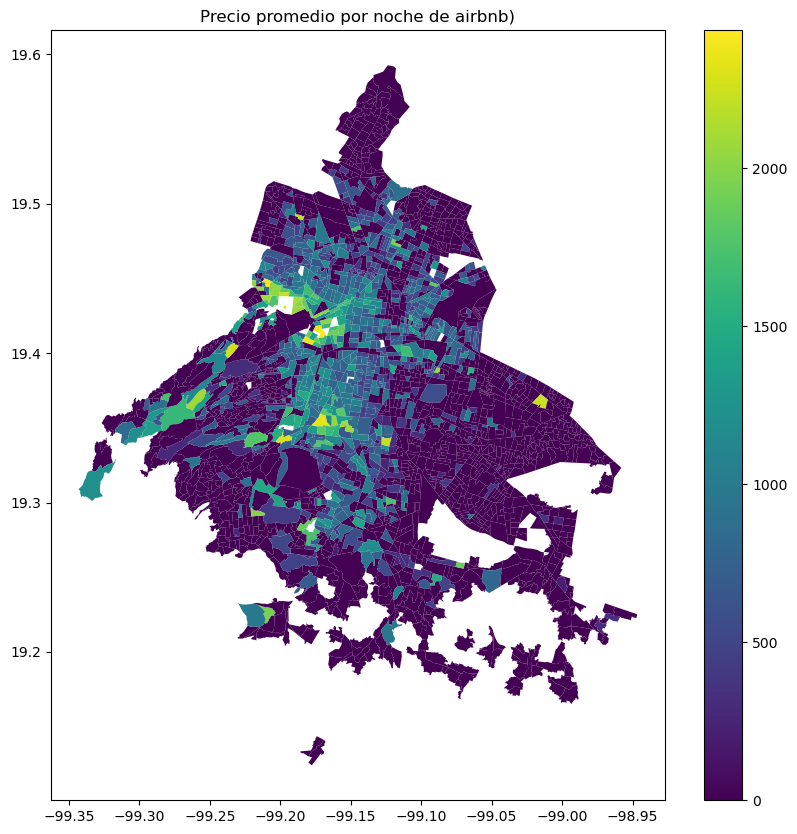

In [8]:
## Visualizamos los precios promedio por agebs
import matplotlib.pyplot as plt 

agebs.query("precio_promedio_x_noche_pesos_airbnb < 2500").plot(column='precio_promedio_x_noche_pesos_airbnb', legend=True,figsize=(10, 10))
plt.title("Precio promedio por noche de airbnb)")
plt.show()

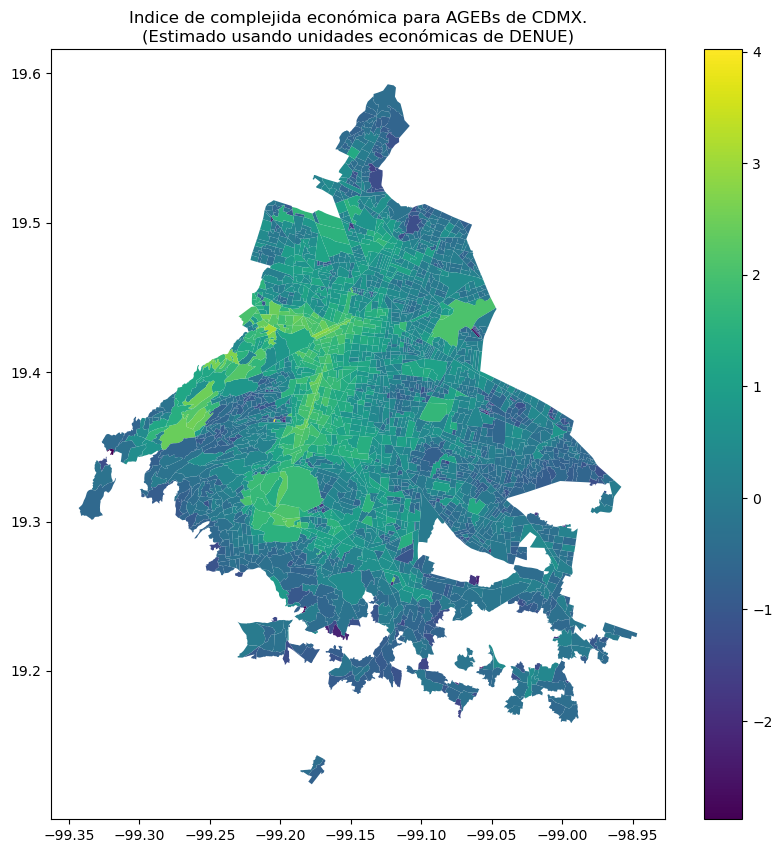

In [9]:
### Agregamos datos de complejidad
## Complejidad agebs
complejidad_agebs = pd.read_csv("complejidad_agebs.zip").drop_duplicates(subset=["CVEGEO"])

## Hacemos el merge
agebs = agebs.merge(right=complejidad_agebs, on = "CVEGEO", how = "inner")

agebs.plot(column='eci', legend=True,figsize=(10, 10))
plt.title("Indice de complejida económica para AGEBs de CDMX.\n(Estimado usando unidades económicas de DENUE)")
plt.show()



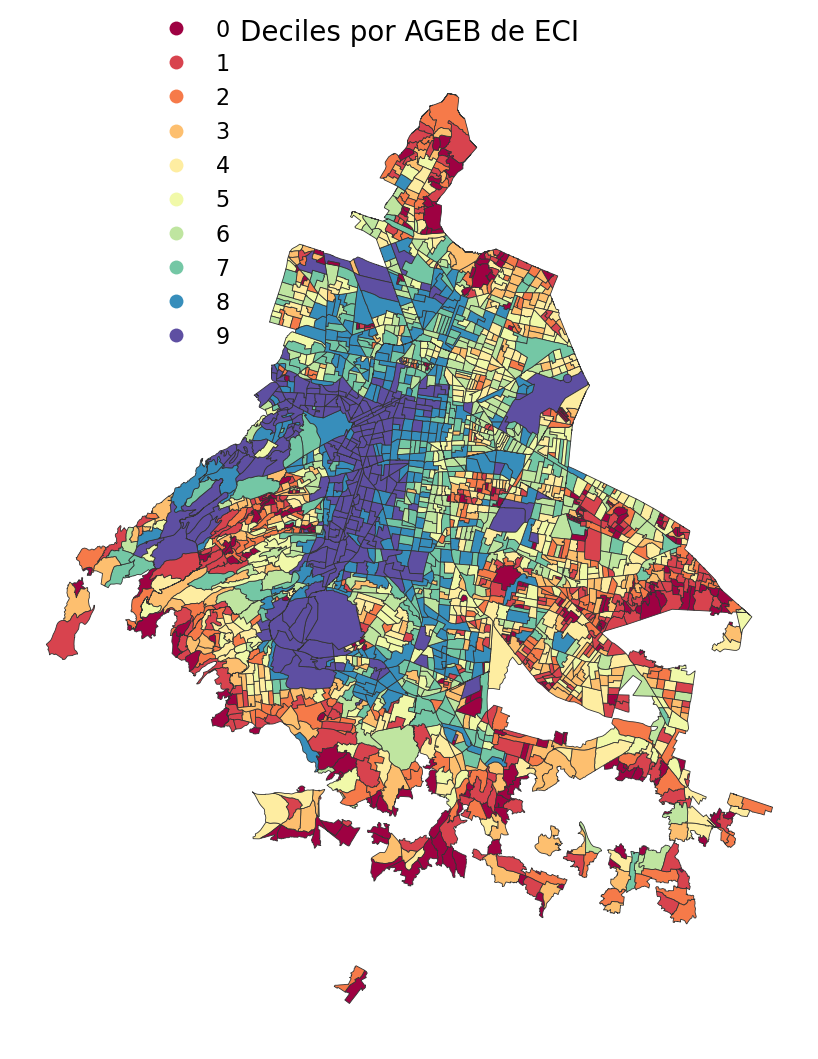

In [14]:
## Construye deciles del ECI

agebs["eci_deciles"] = pd.qcut(agebs['eci'], 10, labels=False)

fig, ax = plt.subplots(1, figsize=(14,13))
agebs.plot(column='eci_deciles', categorical=True, cmap='Spectral', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
ax.set_title('Deciles por AGEB de ECI',fontsize=20)
plt.show()

In [15]:
#### CONSTRUYE INDICADOR RANKING CON LOS PESOS ASOCIADOS AL ECI Y AL PRECIO AIRBNB
agebs["precio_promedio_x_noche_pesos_airbnb_normalizado"] = (agebs["precio_promedio_x_noche_pesos_airbnb"] - agebs["precio_promedio_x_noche_pesos_airbnb"].mean())/ agebs["precio_promedio_x_noche_pesos_airbnb"].std()

peso_eci = 0.8
peso_airbnb = 0.2

agebs["ranking"] = peso_eci * agebs["eci"] + peso_airbnb * agebs["precio_promedio_x_noche_pesos_airbnb_normalizado"]



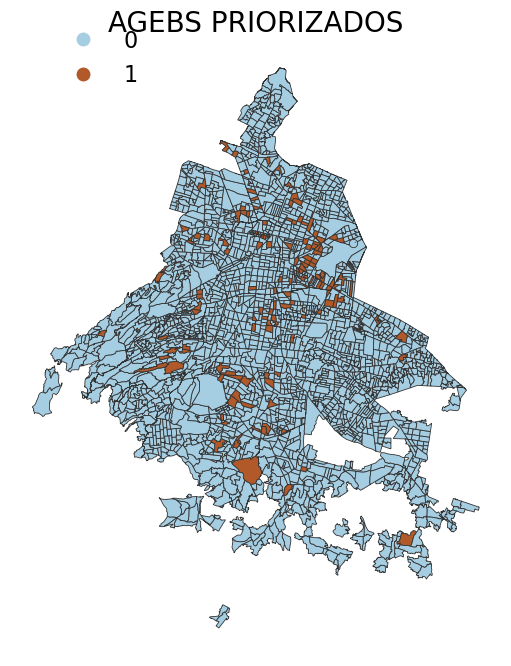

In [22]:
#### Graficamos los N agebs de los deciles 5 y 6 que estan mejor rankeados

N_agebs = 140
agebs_priorizados = agebs.query("eci_deciles==5 or eci_deciles==6").sort_values("ranking").iloc[-N_agebs:]["CVEGEO"].to_list()
agebs["agebs_priorizados"] = 0
agebs.loc[agebs.CVEGEO.isin(agebs_priorizados), "agebs_priorizados"] = 1

fig, ax = plt.subplots(1, figsize=(14,8))
agebs.plot(column='agebs_priorizados', categorical=True, cmap='Paired', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
ax.set_title('AGEBS PRIORIZADOS',fontsize=20)
plt.show()

In [23]:
agebs

,NOM_MUN_x,clave,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,Ambito,ENTIDAD,NOM_ENT,...,geometry,precio_promedio_x_noche_pesos_airbnb,conteos_airbnb,codigo_act,eci,pci,eci_deciles,precio_promedio_x_noche_pesos_airbnb_normalizado,ranking,agebs_priorizados
0,Álvaro Obregón,09010,0901000011716,09,010,0001,1716,Urbana,9,Ciudad de México,...,"POLYGON ((-99.26045 19.32045, -99.26057 19.320...",0.0000,0,1125,-0.472403,-0.050933,2,-0.535363,-0.484995,0
1,Álvaro Obregón,09010,0901000012150,09,010,0001,2150,Urbana,9,Ciudad de México,...,"POLYGON ((-99.1917 19.37893, -99.1917 19.37879...",916.1560,5,1125,0.699437,-0.050933,7,0.908351,0.741220,0
2,Álvaro Obregón,09010,0901000011133,09,010,0001,1133,Urbana,9,Ciudad de México,...,"MULTIPOLYGON (((-99.18857 19.34015, -99.18857 ...",1045.2000,5,1125,1.843023,-0.050933,9,1.111704,1.696759,0
3,Álvaro Obregón,09010,0901000011307,09,010,0001,1307,Urbana,9,Ciudad de México,...,"MULTIPOLYGON (((-99.20565 19.30622, -99.20565 ...",1464.1175,4,1125,1.586254,-0.050933,9,1.771850,1.623373,0
4,Álvaro Obregón,09010,0901000010281,09,010,0001,0281,Urbana,9,Ciudad de México,...,"POLYGON ((-99.24233 19.38449, -99.24287 19.383...",0.0000,0,1125,0.892869,-0.050933,8,-0.535363,0.607223,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426,Álvaro Obregón,09010,0900700012564,09,007,0001,2564,Urbana,9,Ciudad de México,...,"POLYGON ((-99.00255 19.35534, -99.00154 19.355...",0.0000,0,1125,-0.138100,-0.050933,4,-0.535363,-0.217553,0
2427,Álvaro Obregón,09010,0900700012615,09,007,0001,2615,Urbana,9,Ciudad de México,...,"POLYGON ((-98.99889 19.3544, -98.99874 19.3543...",0.0000,0,1125,-0.549979,-0.050933,1,-0.535363,-0.547055,0
2428,Álvaro Obregón,09010,0900700012969,09,007,0001,2969,Urbana,9,Ciudad de México,...,"POLYGON ((-98.98367 19.34556, -98.98364 19.345...",0.0000,0,1125,-0.600975,-0.050933,1,-0.535363,-0.587852,0
2429,Álvaro Obregón,09010,0900700013721,09,007,0001,3721,Urbana,9,Ciudad de México,...,"POLYGON ((-99.06042 19.36215, -99.06052 19.361...",341.0900,1,1125,-0.258792,-0.050933,3,0.002140,-0.206606,0


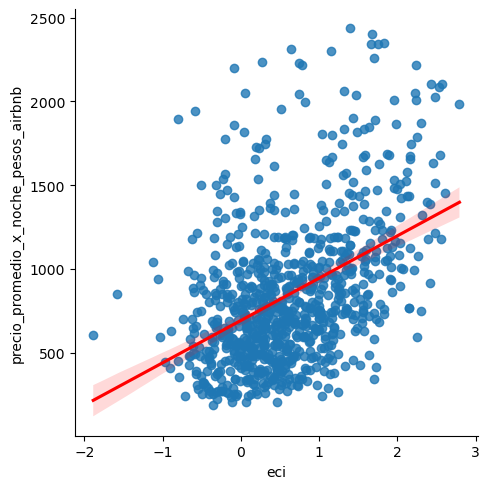

In [32]:
import seaborn as sns

sns.lmplot(x='eci',y='precio_promedio_x_noche_pesos_airbnb',  line_kws={'color': 'red'},data=agebs.query("precio_promedio_x_noche_pesos_airbnb < 2500 and precio_promedio_x_noche_pesos_airbnb !=0"),fit_reg=True) 


In [ ]:
agebs.to_csv("agebs_priorizado.csv", index = False)